**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](manipulation.csail.mit.edu/pick.html).**

# Notebook setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- launch a server for our 3D visualizer (MeshCat) that will be used for the remainder of this notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast because the machine will already have drake installed.

In [67]:
import importlib
import sys
from urllib.request import urlretrieve

# TODO(russt): install only drake (not manipulation) after colab gets to python3.8
if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='c1bdae733682f8a390f848bc6cb0dbbf9ea98602', drake_version='0.27.0', drake_build='release')

from manipulation import running_as_notebook

# Install pyngrok.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)


# Let's do all of our imports here, too.
import numpy as np
import altair as alt
import pydot
from IPython.display import display, SVG
from ipywidgets import Text, Textarea, Layout
import plotly.express as px

from pydrake.all import (
    AddMultibodyPlantSceneGraph, AngleAxis, BasicVector, ConnectMeshcatVisualizer, 
    DiagramBuilder, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
    LeafSystem, MultibodyPlant, MultibodyPositionToGeometryPose, Parser, 
    PiecewisePolynomial, PiecewiseQuaternionSlerp, Quaternion, RigidTransform, 
    RollPitchYaw, RotationMatrix, SceneGraph, Simulator, TrajectorySource
)
from pydrake.examples.manipulation_station import ManipulationStation
from pydrake.multibody.jupyter_widgets import MakeJointSlidersThatPublishOnCallback

# TODO(russt): Move this to drake (adding the element name support to the base class).
import pandas as pd

def dataframe(trajectory, times, names):
  assert trajectory.rows() == len(names)
  values = trajectory.vector_values(times)
  data = {'t': times }
  for i in range(len(names)):
    data[names[i]] = values[i,:]
  return pd.DataFrame(data)

# Inspecting the kinematic tree

Here is a simple example that demonstrates how to inspect the kinematic tree stored in a `MultibodyPlant`.

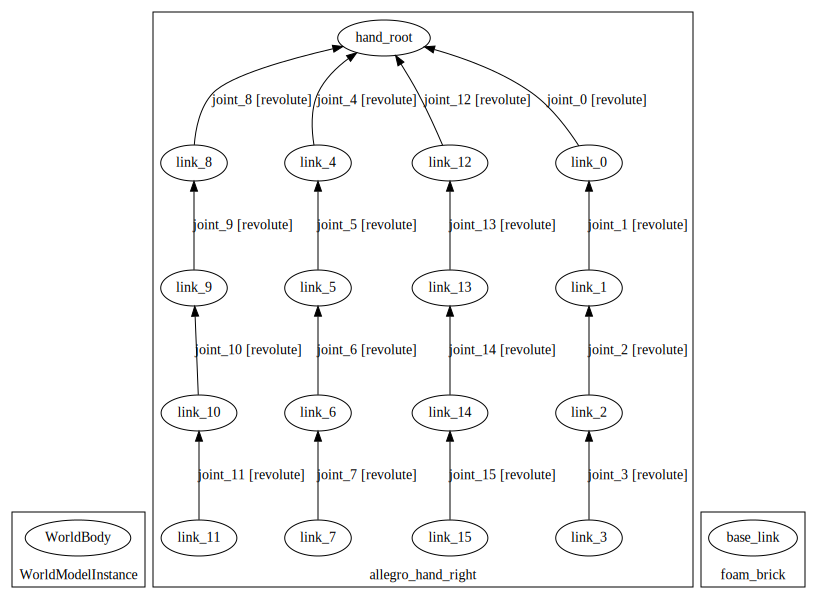

In [68]:
def kinematic_tree_example():
    plant = MultibodyPlant(time_step=0.0)
    parser = Parser(plant)
    parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf"))
    parser.AddModelFromFile(FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf"))
    plant.Finalize()

    # TODO(russt): Add floating base connections
    # TODO(russt): Consider a more interactive javascript rendering?
    display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))

kinematic_tree_example()

# Forward kinematics of the gripper frame

Here is a simple example that let's you visualize the frames on the iiwa and the gripper.  If you click on the "Open Controls" menu in the MeshCat visualizer, and dig into the menu `meshcat->drake->Source` then you will see elements for each of the models in the `SceneGraph`: one for the iiwa, another for the WSG, and others for the clutter bins.  You can enable/disable their visualization.  Give it a spin!

In [69]:
def gripper_forward_kinematics_example():
    builder = DiagramBuilder()

    # TODO: Replace this with a simple model directive of iiwa+wsg (no clutter bins)
    station = builder.AddSystem(ManipulationStation())
    station.SetupClutterClearingStation()
    station.Finalize()

    frames_to_draw = {"iiwa": {"iiwa_link_1", "iiwa_link_2", "iiwa_link_3", "iiwa_link_4", "iiwa_link_5", "iiwa_link_6", "iiwa_link_7"},
                      "gripper": {"body"}}
    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("query_object"),
        zmq_url=zmq_url,
        frames_to_draw=frames_to_draw,
        axis_length=0.3,
        axis_radius=0.01)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    xyz = Text(value="", description="gripper position (m): ", layout=Layout(width='500px'), style={'description_width':'initial'})
    rpy = Text(value="", description="gripper roll-pitch-yaw (rad): ", layout=Layout(width='500px'), style={'description_width':'initial'})
    plant = station.get_multibody_plant()

    gripper = plant.GetBodyByName("body")
    def pose_callback(context):
        pose = plant.EvalBodyPoseInWorld(context, gripper)   ## This is the important line
        xyz.value = np.array2string(pose.translation(), formatter={'float': lambda x: "{:3.2f}".format(x)})
        rpy.value = np.array2string(RollPitchYaw(pose.rotation()).vector(), formatter={'float': lambda x: "{:3.2f}".format(x)})

    meshcat.load()
    MakeJointSlidersThatPublishOnCallback(station.get_multibody_plant(), meshcat, context, my_callback=pose_callback)
    display(xyz)
    display(rpy)

gripper_forward_kinematics_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


/home/kiwi/soft/virenv/pdrake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:438: UserWarning:

Non-existent frame gripper ignored

/home/kiwi/soft/virenv/pdrake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:438: UserWarning:

Non-existent frame iiwa ignored



FloatSlider(value=-1.57, description='iiwa_joint_1', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, …

FloatSlider(value=0.1, description='iiwa_joint_2', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_3', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=-1.2, description='iiwa_joint_4', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, ste…

FloatSlider(value=0.0, description='iiwa_joint_5', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=1.6, description='iiwa_joint_6', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_7', layout=Layout(width="'200'"), max=3.05433, min=-3.05433, st…

FloatSlider(value=-0.05, description='left_finger_sliding_joint', layout=Layout(width="'200'"), max=0.0, min=-…

FloatSlider(value=0.05, description='right_finger_sliding_joint', layout=Layout(width="'200'"), max=0.055, ste…

Text(value='[0.00 -0.47 0.66]', description='gripper position (m): ', layout=Layout(width='500px'), style=Desc…

Text(value='[-1.81 -0.00 0.00]', description='gripper roll-pitch-yaw (rad): ', layout=Layout(width='500px'), s…

# Don't assume $\dot{q} \equiv v$

Let's just add a single object into the scene.  We won't weld it to the world frame, so it is a "free body" or has a "floating base".

In [70]:
def num_positions_velocities_example():
    plant = MultibodyPlant(time_step = 0.0)
    Parser(plant).AddModelFromFile(FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf"))
    plant.Finalize()

    context = plant.CreateDefaultContext()
    print(context)

    print(f"plant.num_positions() = {plant.num_positions()}")
    print(f"plant.num_velocities() = {plant.num_velocities()}")

num_positions_velocities_example()

::_ Context
------------
Time: 0
States:
  13 continuous states
    1 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  3 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
             0.028           0           0       0.025  0.00104286  0.00130357 0.000678571           0           0           0
     12 parameters
        1  0  0  0  1  0  0  0  1 -0 -0 -0

plant.num_positions() = 7
plant.num_velocities() = 6


Looking at the `Context` you can see that this system has 13 total state variables.  7 of them are positions, $q$; this is due to our pose representation using unit quaternions.  But only 6 of them are velocities, $v$; this is because a six-element spatial velocity provides a better (unconstrained) representation of the rate of change of the unit quaternion.  But clearly, if the length of the vectors don't even match, we do *not* have $\dot{q} = v$.

# Kinematic Jacobians for pick and place

Let's set up the same iiwa + wsg example, with sliders (but without the frames), that we used above.  But this time I'll display the value of the Jacobian $J^G(q)$.

In [71]:
def pick_and_place_jacobians_example():
    builder = DiagramBuilder()

    # TODO: Replace this with a simple model directive of iiwa+wsg (no clutter bins)
    station = builder.AddSystem(ManipulationStation())
    station.SetupClutterClearingStation()
    station.Finalize()

    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("query_object"),
#        delete_prefix_on_load=False,
        zmq_url=zmq_url)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    jacobian = Textarea(value="", description="J_G: ", layout={'width':'60%','height':'100px'}, style={'description_width':'initial'})
    sigma = Text(value="", description="smallest singular value(J_G): ", layout={'width':'60%'}, style={'description_width':'initial'})
    plant = station.get_multibody_plant()

    G = plant.GetBodyByName("body").body_frame()
    W = plant.world_frame()
    def pose_callback(context):
        J_G = plant.CalcJacobianSpatialVelocity(context, JacobianWrtVariable.kQDot, G, [0,0,0], W, W)   ## This is the important line
        jacobian.value = np.array2string(J_G, formatter={'float': lambda x: "{:5.1f}".format(x)})
        sigma.value = str(np.min(np.linalg.svd(J_G, compute_uv=False)))

    meshcat.load()

    # If you want to set the initial positions manually, use this:
    #plant.SetPositions(plant.GetMyContextFromRoot(context),
    #                   plant.GetModelInstanceByName("iiwa"),
    #                   [0, 0, 0, 0, 0, 0, 0])

    MakeJointSlidersThatPublishOnCallback(station.get_multibody_plant(), meshcat, context, my_callback=pose_callback)
    display(jacobian)
    display(sigma)

pick_and_place_jacobians_example()


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


FloatSlider(value=-1.57, description='iiwa_joint_1', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, …

FloatSlider(value=0.1, description='iiwa_joint_2', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_3', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=-1.2, description='iiwa_joint_4', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, ste…

FloatSlider(value=0.0, description='iiwa_joint_5', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=1.6, description='iiwa_joint_6', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_7', layout=Layout(width="'200'"), max=3.05433, min=-3.05433, st…

FloatSlider(value=-0.05, description='left_finger_sliding_joint', layout=Layout(width="'200'"), max=0.0, min=-…

FloatSlider(value=0.05, description='right_finger_sliding_joint', layout=Layout(width="'200'"), max=0.055, ste…

Textarea(value='[[  0.0   1.0   0.0  -1.0   0.0   1.0   0.0   0.0   0.0]\n [  0.0   0.0  -0.1  -0.0  -1.0   0.…

Text(value='0.1793103962164519', description='smallest singular value(J_G): ', layout=Layout(width='60%'), sty…

# Our first end-effector "controller"

Let's use the pseudo-inverse of the Jacobian to drive the robot around.  To do that, we'll write a very simple system that looks at the current value of $q$, computes $[J^G]^+$, and uses it to command a constant spatial velocity, $V^G$.

We'll only run this controller for a short duration.  Constant spatial velocities aren't something that makes sense for a longer simulation!

Make sure you try changing $V^G$, and understand how the command relates to the motion of the robot.

In [72]:
# We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        q = self.get_input_port().Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,0:7] # Ignore gripper terms
        
        V_G_desired = np.array([0,    # rotation about x
                                -.1,  # rotation about y
                                0,    # rotation about z
                                0,    # x
                                -.05, # y
                                -.1]) # z
        v = np.linalg.pinv(J_G).dot(V_G_desired)
        output.SetFromVector(v)

        
def jacobian_controller_example():
    builder = DiagramBuilder()

    station = builder.AddSystem(ManipulationStation())
    station.SetupClutterClearingStation()
    station.Finalize()

    controller = builder.AddSystem(PseudoInverseController(
        station.get_multibody_plant()))
    integrator = builder.AddSystem(Integrator(7))

    builder.Connect(controller.get_output_port(), 
                    integrator.get_input_port())
    builder.Connect(integrator.get_output_port(),
                    station.GetInputPort("iiwa_position"))
    builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                    controller.get_input_port())

    meshcat = ConnectMeshcatVisualizer(builder,
        station.get_scene_graph(),
        output_port=station.GetOutputPort("query_object"),
        zmq_url=zmq_url)

    diagram = builder.Build()
    simulator = Simulator(diagram)
    station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
    station.GetInputPort("iiwa_feedforward_torque").FixValue(station_context, np.zeros((7,1)))
    station.GetInputPort("wsg_position").FixValue(station_context, [0.1])
    # TODO(russt): Add this missing python binding
    #integrator.set_integral_value(
    #    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
    #        station.GetIiwaPosition(station_context))
    integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01);

    return simulator

simulator = jacobian_controller_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


In [73]:
# Wait for the model to load in the visualizer, then run this cell to see the interesting part...
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);

# Compute grasp and pregrasp poses

Here is a simple example with a floating Schunk gripper and the foam brick.  It defines the grasp pose as described in the notes, and renders it to the 3D visualizer.

**Check yourself**: Try changing the grasp pose to our pregrasp pose.  Do you like the numbers that I picked in the text?

In [74]:
def grasp_poses_example():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant, scene_graph)
    grasp = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "grasp")
    # TODO(russt): Draw the pregrasp gripper, too, as transparent (drake #13970).
    #pregrasp = parser.AddModelFromFile(FindResourceOrThrow(
    #    "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "pregrasp")
    brick = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf"))
    plant.Finalize()

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    # TODO(russt): Set a random pose of the object.

    # Get the current object, O, pose
    B_O = plant.GetBodyByName("base_link", brick)
    X_WO = plant.EvalBodyPoseInWorld(plant_context, B_O)

    B_Ggrasp = plant.GetBodyByName("body", grasp)
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
        RotationMatrix.MakeZRotation(np.pi/2.0))
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    X_WGgrasp = X_WO.multiply(X_OGgrasp)

    plant.SetFreeBodyPose(plant_context, B_Ggrasp, X_WGgrasp)
    # Open the fingers, too.
    plant.GetJointByName("left_finger_sliding_joint", grasp).set_translation(plant_context, -0.054)
    plant.GetJointByName("right_finger_sliding_joint", grasp).set_translation(plant_context, 0.054)

    meshcat.load()
    diagram.Publish(context)

grasp_poses_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


# A pick and place "sketch" with keyframes

Let's first define the canonical frames of our problem.  We've got a handful of them, and will pass them in and out of several functions, so I'll use a dictionary to store them.

*Edit*: I've added one more frame into the mix here, to get some clearance when moving between the bins.  Leaving it out gave my a nice [robot outtake](http://manipulation.csail.mit.edu/data/pick_fail.html), but we can do better.

In [75]:
def make_gripper_frames(X_G, X_O):
  """
  Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
  returns a X_G and times with all of the pick and place frames populated.
  """
  # Define (again) the gripper pose relative to the object when in grasp.
  p_GgraspO = [0, 0.12, 0]
  R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
      RotationMatrix.MakeZRotation(np.pi/2.0))
  X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
  X_OGgrasp = X_GgraspO.inverse()
  # pregrasp is negative y in the gripper frame (see the figure!).
  X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

  X_G["pick"] = X_O["initial"].multiply(X_OGgrasp)
  X_G["prepick"] = X_G["pick"].multiply(X_GgraspGpregrasp)
  X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
  X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

  # I'll interpolate a ahlfway orientation by converting to axis angle and halving the angle.
  X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
  angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
  X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
                                        X_GprepickGpreplace.translation()/2.0 + np.array([0, -0.3, 0]))
  X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

  # Now let's set the timing
  times = {"initial": 0}
  X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
  times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
  # Allow some time for the gripper to close.
  times["pick_start"] = times["prepick"] + 2.0
  times["pick_end"] = times["pick_start"] + 2.0
  times["postpick"] = times["pick_end"] + 2.0
  time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
  times["clearance"] = times["postpick"] + time_to_from_clearance
  times["preplace"] = times["clearance"] + time_to_from_clearance
  times["place_start"] = times["preplace"] + 2.0
  times["place_end"] = times["place_start"] + 2.0
  times["postplace"] = times["place_end"] + 2.0

  return X_G, times

X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2.0), [0, -0.25, 0.25])}
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

Sanity check: The entire maneuver will take 30.900220749318255 seconds to execute.


Here's a simple visualization of those frames.  Use the controls menu in meshcat to view the different objects on the different "paths" to understand which objects belong to which frames.  Everything look reasonable?

Try changing the initial and final pose of the gripper / object.

In [76]:
def visualize_gripper_frames(X_G, X_O):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant, scene_graph)
    gripper = FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf")
    brick = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")
    for key, pose in X_G.items():
      g = parser.AddModelFromFile(gripper, f"gripper_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body", g), pose)
    for key, pose in X_O.items():
      o = parser.AddModelFromFile(brick, f"object_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)

    plant.Finalize()


    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    meshcat.load()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

visualize_gripper_frames(X_G, X_O)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


# Pick and place trajectories

We've defined the keyframes, but now we will fill in timing details (what should be happening at each instant).  Interpolating between the positions is quite simple; we can encode these details as a `PiecewisePolynomial` trajectory in $\Re^3$ over time.

TODO(russt): Maybe implement `PiecewisePose` with an append workflow.

In [77]:
def make_gripper_position_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    # The syntax here is a little ugly; we need to pass in a matrix with the samples in the columns.
    # TODO(russt): Add python bindings for the std::vector constructor.
    traj = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

    # TODO(russt): I could make this less brittle if I was more careful on the names above, and just look up the pose for every time (in order)
    traj.AppendFirstOrderSegment(times["pick_start"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
    traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
    traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
    traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

    return traj

traj_p_G = make_gripper_position_trajectory(X_G, times)

Now let's plot our trajectories.  `Altair` is a plotting library built on Pandas and Vega-lite (to support interactive graphics), which works well in Colab.  I aim to start using it more.  

<sup><sub>TODO(russt): Add mouseover interaction that publishes to meshcat, so that a cursor on this plot renders the corresponding pose.(Unfortunately, I don't believe I can link a callback to python with altair).</sub></sup>

In [78]:
data = dataframe(traj_p_G, traj_p_G.get_segment_times(), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

Unfortunately, Altair doesn't do 3D plotting (neither does mpld3), so here is the Plotly Express version.

In [79]:
data = dataframe(traj_p_G, np.linspace(traj_p_G.start_time(), traj_p_G.end_time(), 50), ['x','y','z'])
fig = px.line_3d(data, x='x', y='y', z='z')
fig.update_traces(mode='lines+markers',
                  marker=dict(size=3, color="rgb(153, 51, 51)"),
                  line=dict(color="rgb(153, 51, 51)"))
if running_as_notebook:
    fig.show()

We also need to come up with a time trajectory for the orientations of our gripper.  Simple straight-line interpolation between rotations doesn't work particularly well, no matter how you are representing your rotations.  We'll use the quaternion "slerp" here (short for "spherical linear interpolation"), using the `PiecewiseQuaternionSlerp` trajectory class.

In [80]:
def make_gripper_orientation_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    traj = PiecewiseQuaternionSlerp();
    traj.Append(times["initial"], X_G["initial"].rotation())
    traj.Append(times["prepick"], X_G["prepick"].rotation())
    traj.Append(times["pick_start"], X_G["pick"].rotation())
    traj.Append(times["pick_end"], X_G["pick"].rotation())
    traj.Append(times["postpick"], X_G["prepick"].rotation())
    traj.Append(times["clearance"], X_G["clearance"].rotation())
    traj.Append(times["preplace"], X_G["preplace"].rotation())
    traj.Append(times["place_start"], X_G["place"].rotation())
    traj.Append(times["place_end"], X_G["place"].rotation())
    traj.Append(times["postplace"], X_G["preplace"].rotation())

    return traj

traj_R_G = make_gripper_orientation_trajectory(X_G, times)

We can plot the orientation trajectory, too.  Here are the components of the quaternion over time.

In [81]:
data = dataframe(traj_R_G, traj_R_G.get_segment_times(), ['x','y','z','w'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='w').properties(height=80)
)

alt.VConcatChart(...)

Better, I think, to just plot the entire result.  Before we do, let's quickly define the finger trajectory.

In [82]:
opened = np.array([0.107]);
closed = np.array([0.0]);

def make_wsg_command_trajectory(times):
    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]], np.hstack([[opened], [opened]]))
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    return traj_wsg_command

traj_wsg_command = make_wsg_command_trajectory(times)

In [83]:
data = dataframe(traj_wsg_command, traj_wsg_command.get_segment_times(), ['wsg'])
alt.Chart(data).mark_line().encode(x='t', y='wsg').properties(height=80)

alt.Chart(...)

Now let's really visualize the trajectory.  The best way is to animate it in 3D!  Please forgive the messiness of this particular bit of code; I'm trying to provide some intermediate steps that aren't typically used by the main drake developers.

TODO(russt): make this less "bespoke".

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
::_::drake/multibody/MultibodyPlant@000000000f8fbc70 Context
-------------------------------------------------------------
Time: 0
States:
  30 continuous states
            1         0         0         0         0 -0.049133         0  0.707107         0         0  0.707107      -0.2     -0.75     0.025         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0

Parameters:
  16 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
       0.988882        0        0        0 0.164825 0.164825 0.166667        0        0        0
     10 parame

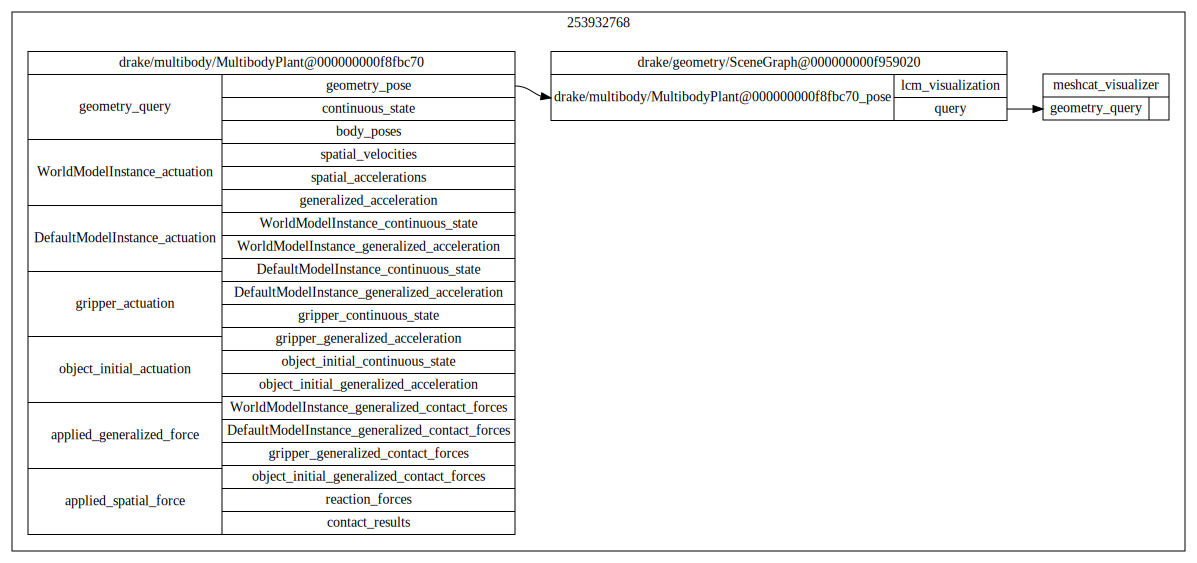

RuntimeError: Actuation input port for model instance gripper must be connected.

In [66]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("body")
#         self.brick_body = plant.GetBodyByName("base_link")
        self.left_finger_joint = plant.GetJointByName("left_finger_sliding_joint")
        self.right_finger_joint = plant.GetJointByName("right_finger_sliding_joint")
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort("position", 
                                     BasicVector(plant.num_positions()),
                                     self.CalcPositionOutput)

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t))
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
#         self.plant.SetFreeBodyPose(self.plant_context, self.brick_body, X_G)
        wsg = self.traj_wsg_command.value(t)
        self.left_finger_joint.set_translation(self.plant_context, -wsg/2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg/2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))

def visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O):
    builder = DiagramBuilder()

    # Note: Don't use AddMultibodyPlantSceneGraph because we are only using
    # MultibodyPlant for parsing, then wiring directly to SceneGraph.
    
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(time_step=0.0)
    builder.AddSystem(plant)
#     source_id = plant.RegisterAsSourceForSceneGraph(scene_graph)
#     print(source_id)
#     plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant, scene_graph)
    gripper = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "gripper")
    brick = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")
#     for key, pose in X_O.items():
    o = parser.AddModelFromFile(brick, "object_initial")#f"object_{key}"
#       plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)
    plant.Finalize()
    
    
    builder.Connect(plant.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))
#     to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
#     builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

#     traj_to_position = builder.AddSystem(GripperTrajectoriesToPosition(plant, traj_p_G, traj_R_G, traj_wsg_command))
#     builder.Connect(traj_to_position.get_output_port(), to_pose.get_input_port())

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

    diagram = builder.Build()
    
    meshcat.load()
    context = diagram.CreateDefaultContext()
#     plant_context = plant.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    publishing_context = meshcat.GetMyContextFromRoot(context)
    brick_body = plant.GetBodyByName("base_link")
    plant.SetFreeBodyPose(plant_context, brick_body, X_O["initial"])
#     pose = plant.GetFreeBodyPose(plant_context, brick_body)
#     X_WG = plant.EvalBodyPoseInWorld(plant_context, brick_body)
    print(plant_context)
#     meshcat.Publish(publishing_context)
#     diagram.Publish(context)
    plant.get_actuation_input_port().FixValue(plant_context, np.zeros(2));

    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
#     SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[0].create_svg())
    simulator = Simulator(diagram)
    meshcat.start_recording()
    simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
    meshcat.publish_recording()

visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)

# Putting it all together

In the visualization above, we animated the plan, but did not actually command the robot!  Let's put our grasping trajectories back together with our Jacobian-based controller.

The first thing you might have noticed is that the Jacobian controller takes spatial velocities as input.  But so far we have trajectories for positions and orientations.  Let's differentiate them to get the velocities.

In [84]:
traj_v_G = traj_p_G.MakeDerivative()
traj_w_G = traj_R_G.MakeDerivative()

data = dataframe(traj_v_G, np.linspace(traj_v_G.start_time(), traj_v_G.end_time()), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

Now we need a slightly modified version of our Jacobian controller, which can take the spatial velocity commands from an input port.

In [85]:
# We can write a new System by deriving from the LeafSystem class.
# There is a little bit of boiler plate, but hopefully this example makes sense.
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.w_G_port = self.DeclareVectorInputPort("omega_WG", BasicVector(3))
        self.v_G_port = self.DeclareVectorInputPort("v_WG", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), 
                                     self.CalcOutput)
        # TODO(russt): Add missing binding
        #joint_indices = plant.GetJointIndices(self._iiwa)
        #self.position_start = plant.get_joint(joint_indices[0]).position_start()
        #self.position_end = plant.get_joint(joint_indices[-1]).position_start()
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        w_G = self.w_G_port.Eval(context)
        v_G = self.v_G_port.Eval(context)
        V_G = np.hstack([w_G, v_G])
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

Oh, boy.  Big moment.  I'm excited... are you?  Let's do this thing!

In [86]:
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.65, 0.09]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.5, 0, 0.09])}

builder = DiagramBuilder()

station = builder.AddSystem(ManipulationStation())
station.SetupClutterClearingStation()
station.AddManipulandFromFile(
    "drake/examples/manipulation_station/models/061_foam_brick.sdf",
    X_O["initial"])
station.Finalize()

# Find the initial pose of the gripper (as set in the default Context)
temp_context = station.CreateDefaultContext()
plant = station.get_multibody_plant()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {"initial": plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("body"))}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

# Make the trajectories
traj_p_G = make_gripper_position_trajectory(X_G, times)
traj_v_G = traj_p_G.MakeDerivative()
traj_R_G = make_gripper_orientation_trajectory(X_G, times)
traj_w_G = traj_R_G.MakeDerivative()

v_G_source = builder.AddSystem(TrajectorySource(traj_v_G))
v_G_source.set_name("v_WG")
w_G_source = builder.AddSystem(TrajectorySource(traj_w_G))
w_G_source.set_name("omega_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(v_G_source.get_output_port(), controller.GetInputPort("v_WG"))
builder.Connect(w_G_source.get_output_port(), controller.GetInputPort("omega_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), 
                integrator.get_input_port())
builder.Connect(integrator.get_output_port(),
                station.GetInputPort("iiwa_position"))
builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                controller.GetInputPort("iiwa_position"))

traj_wsg_command = make_wsg_command_trajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg_command")
builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg_position"))

meshcat = ConnectMeshcatVisualizer(builder,
    station.get_scene_graph(),
    output_port=station.GetOutputPort("query_object"),
#    delete_prefix_on_load=False,  # Use this if downloading is a pain.
    zmq_url=zmq_url,
)

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
# TODO(russt): Add this missing python binding
#integrator.set_integral_value(
#    integrator.GetMyContextFromRoot(simulator.get_mutable_context()), 
#        station.GetIiwaPosition(station_context))
integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))

simulator.set_target_realtime_rate(1.0)
meshcat.start_recording()
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
meshcat.stop_recording()
meshcat.publish_recording()


Sanity check: The entire maneuver will take 27.819595226260763 seconds to execute.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


That's quite some diagram we've assembled.  Do you understand all of the parts?

In [ ]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[0].create_svg())